In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("dataset.csv")

In [4]:
df.head()

,gamePk,home_offense,home_power,home_clutch,home_r_oppBa,home_r_oppBb,home_r_oppEr,home_s_oppBa,home_s_oppBb,home_s_oppEr,away_offense,away_power,away_clutch,away_r_oppBa,away_r_oppBb,away_r_oppEr,away_s_oppBa,away_s_oppBb,away_s_oppEr,homeTeam_win
0,566180,0.363636,0.079365,0.285714,0.163934,0.075758,0.333333,0.258922,0.089009,0.368218,0.315068,0.250000,0.391304,0.253968,0.112676,0.375000,0.258785,0.089063,0.368410,0.0
1,565316,0.220000,0.055556,0.227273,0.230769,0.099010,0.354839,0.258922,0.089009,0.368218,0.321739,0.155340,0.405405,0.218750,0.102804,0.468750,0.258785,0.089063,0.368410,1.0
2,567459,0.412371,0.187500,0.325000,0.240385,0.079646,0.294118,0.258922,0.089008,0.368218,0.254902,0.074074,0.153846,0.176923,0.084507,0.314286,0.258785,0.089063,0.368410,1.0
3,565223,0.238095,0.172414,0.333333,0.223881,0.182927,0.200000,0.258921,0.089010,0.368217,0.335766,0.235294,0.369565,0.237410,0.085526,0.413043,0.258785,0.089064,0.368412,0.0
4,566868,0.246479,0.092308,0.342857,0.155556,0.111842,0.157895,0.258919,0.089009,0.368213,0.300885,0.125000,0.411765,0.277228,0.192000,0.288462,0.258785,0.089063,0.368410,0.0


In [5]:
from sklearn.model_selection import train_test_split

In [9]:
train_set,test_set = train_test_split(df,test_size=.2,random_state=12,shuffle=True)

In [11]:
games = train_set.copy()

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve

In [66]:
def plot_confusion_matrix(true,predicted):
    import itertools
    cm=confusion_matrix(true,predicted)
    classes=['Home Team Loss','Home Team Win']
    
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    #plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    plt.grid(b=None)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="black" if cm[i, j] > thresh else "black")
    plt.show()

def pipeline_cv(splits, X, Y, pipeline, average_method=None):
    
    kfold = KFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc_scores = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = fit.predict(X.iloc[test])
        
        scores = fit.score(X.iloc[test],Y.iloc[test])
        
        display(pd.DataFrame(metrics.classification_report(Y.iloc[test],prediction,output_dict=True)))
        accuracy.append(scores * 100)
        precision.append(precision_score(Y.iloc[test], prediction)*100)
        
        #print('precision:',precision_score(Y[test], prediction))
        recall.append(recall_score(Y.iloc[test], prediction)*100)
        #print('recall:   ',recall_score(Y[test], prediction))
        f1.append(f1_score(Y.iloc[test], prediction)*100)
        #print('f1 score: ',f1_score(Y[test], prediction))
        #print('-'*50)
        
        roc_auc_scores.append(roc_auc_score(Y.iloc[test],prediction)*100)
        
        plot_confusion_matrix(Y.iloc[test],prediction)
        
        

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    print("roc_auc score: %.2f%% (+/- %.2f%%)" % (np.mean(roc_auc_scores), np.std(roc_auc_scores)))

In [67]:
lr_clf = LogisticRegression()

lr_pipe = Pipeline(
    [
        ('scaler',StandardScaler()),
        ('clf',lr_clf)
    ]
)

In [68]:
X = games.drop(columns=['gamePk','homeTeam_win'])
y = games['homeTeam_win']

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.529412,0.557940,0.546632,0.543676,0.544341
recall,0.440217,0.643564,0.546632,0.541891,0.546632
f1-score,0.480712,0.597701,0.546632,0.539207,0.541934
support,184.000000,202.000000,0.546632,386.000000,386.000000


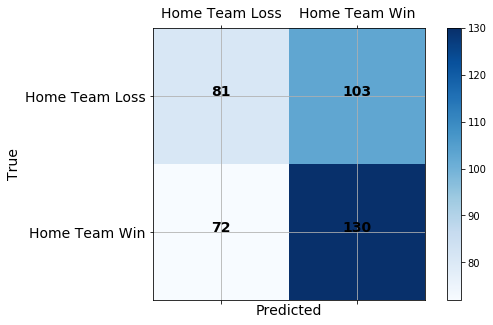

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.576159,0.536170,0.551813,0.556165,0.556475
recall,0.443878,0.663158,0.551813,0.553518,0.551813
f1-score,0.501441,0.592941,0.551813,0.547191,0.546480
support,196.000000,190.000000,0.551813,386.000000,386.000000


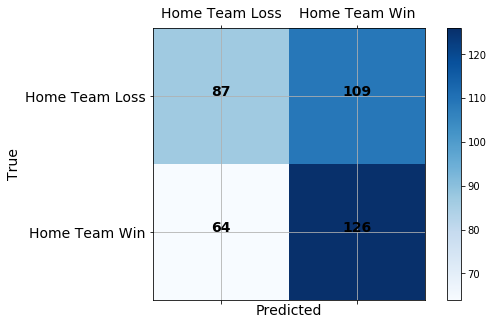

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.562914,0.572650,0.568831,0.567782,0.567971
recall,0.459459,0.670000,0.568831,0.564730,0.568831
f1-score,0.505952,0.617512,0.568831,0.561732,0.563905
support,185.000000,200.000000,0.568831,385.000000,385.000000


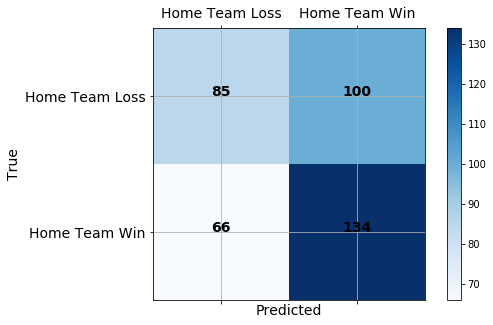

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.546667,0.625532,0.594805,0.586099,0.590708
recall,0.482353,0.683721,0.594805,0.583037,0.594805
f1-score,0.512500,0.653333,0.594805,0.582917,0.591147
support,170.000000,215.000000,0.594805,385.000000,385.000000


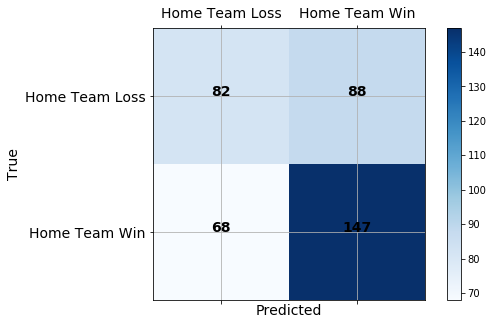

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.566929,0.593023,0.584416,0.579976,0.581027
recall,0.406780,0.735577,0.584416,0.571178,0.584416
f1-score,0.473684,0.656652,0.584416,0.565168,0.572535
support,177.000000,208.000000,0.584416,385.000000,385.000000


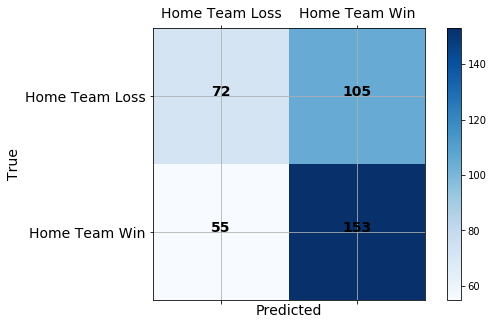

accuracy: 56.93% (+/- 1.84%)
precision: 57.71% (+/- 3.05%)
recall: 67.92% (+/- 3.10%)
f1 score: 62.36% (+/- 2.69%)
roc_auc score: 56.29% (+/- 1.42%)


In [71]:
pipeline_cv(5,X,y,lr_pipe)

In [51]:
games.describe()

,gamePk,home_offense,home_power,home_clutch,home_r_oppBa,home_r_oppBb,home_r_oppEr,home_s_oppBa,home_s_oppBb,home_s_oppEr,away_offense,away_power,away_clutch,away_r_oppBa,away_r_oppBb,away_r_oppEr,away_s_oppBa,away_s_oppBb,away_s_oppEr,homeTeam_win
count,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,566595.125065,0.334994,0.186508,0.381757,0.243697,0.095267,0.345727,0.258919,0.089008,0.368215,0.335505,0.187269,0.382682,0.243574,0.094879,0.345121,0.258782,0.089062,0.368407,0.526725
std,3849.574235,0.022513,0.028944,0.035890,0.017949,0.013112,0.033292,0.000005,0.000003,0.000009,0.021541,0.029260,0.037062,0.018103,0.013150,0.033071,0.000005,0.000003,0.000009,0.499415
min,564734.000000,0.220000,0.055556,0.181818,0.155556,0.055556,0.157895,0.258899,0.088992,0.368181,0.245283,0.067073,0.145833,0.133333,0.031847,0.191176,0.258763,0.089046,0.368374,0.000000
25%,565439.500000,0.321437,0.170243,0.368546,0.233272,0.086949,0.326650,0.258917,0.089006,0.368211,0.322443,0.171182,0.369181,0.232379,0.086682,0.328383,0.258780,0.089061,0.368402,0.000000
50%,566182.000000,0.337192,0.188967,0.382937,0.245059,0.095400,0.345477,0.258920,0.089008,0.368215,0.337464,0.189489,0.384354,0.244706,0.094976,0.345336,0.258783,0.089063,0.368407,1.000000
75%,566920.500000,0.349804,0.204683,0.401510,0.255496,0.103086,0.364417,0.258922,0.089010,0.368220,0.349588,0.205190,0.402241,0.255256,0.102480,0.363416,0.258785,0.089064,0.368412,1.000000
max,599377.000000,0.455056,0.324138,0.510870,0.327684,0.182927,0.500000,0.258938,0.089015,0.368253,0.435065,0.327869,0.524324,0.308271,0.192000,0.472973,0.258801,0.089069,0.368445,1.000000
